In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate, Add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.16.1
Keras version: 3.12.0


In [2]:
# Load dataset
data = np.load('dataset_dev_3000.npz')
X = data['X']
y = data['y']

print(f"Input X shape: {X.shape}")
print(f"Targets y shape: {y.shape}")
print(f"\nTarget A (10-class): range [{y[:, 0].min():.0f}, {y[:, 0].max():.0f}]")
print(f"Target B (32-class): {len(np.unique(y[:, 1]))} classes")
print(f"Target C (Regression): range [{y[:, 2].min():.4f}, {y[:, 2].max():.4f}]")

Input X shape: (3000, 32, 32)
Targets y shape: (3000, 3)

Target A (10-class): range [0, 9]
Target B (32-class): 32 classes
Target C (Regression): range [0.0003, 0.9996]


In [3]:
# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y[:, 0]
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

Training set: (2400, 32, 32)
Validation set: (600, 32, 32)


## Model 1: Single-Task Baseline CNN (Target A only)

In [4]:
def build_baseline_cnn():
    """Simple CNN for Target A (10-class classification)"""
    model = Sequential([
        Input(shape=(32, 32, 1)),
        Conv2D(32, 3, activation='relu', padding='same'),
        MaxPooling2D(2),
        Conv2D(64, 3, activation='relu', padding='same'),
        MaxPooling2D(2),
        Conv2D(64, 3, activation='relu', padding='same'),
        MaxPooling2D(2),
        layers.Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build and display
baseline_model = build_baseline_cnn()
# baseline_model.summary()

In [5]:
# Train baseline model
print("Training baseline model...")

callbacks_baseline = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history_baseline = baseline_model.fit(
    X_train, y_train[:, 0],
    validation_data=(X_val, y_val[:, 0]),
    epochs=50,
    batch_size=64,
    callbacks=callbacks_baseline,
    verbose=2
)

# Evaluate
val_loss, val_acc = baseline_model.evaluate(X_val, y_val[:, 0], verbose=2)
print(f"\n✓ Baseline Model - Validation Accuracy: {val_acc*100:.2f}%")

Training baseline model...
Epoch 1/50
38/38 - 2s - 46ms/step - accuracy: 0.0988 - loss: 2.3085 - val_accuracy: 0.1167 - val_loss: 2.2987 - learning_rate: 0.0010
Epoch 2/50
38/38 - 1s - 16ms/step - accuracy: 0.1146 - loss: 2.2970 - val_accuracy: 0.1500 - val_loss: 2.2859 - learning_rate: 0.0010
Epoch 3/50
38/38 - 1s - 19ms/step - accuracy: 0.1371 - loss: 2.2832 - val_accuracy: 0.1767 - val_loss: 2.2571 - learning_rate: 0.0010
Epoch 4/50
38/38 - 1s - 16ms/step - accuracy: 0.1538 - loss: 2.2497 - val_accuracy: 0.2200 - val_loss: 2.1868 - learning_rate: 0.0010
Epoch 5/50
38/38 - 1s - 16ms/step - accuracy: 0.1621 - loss: 2.2278 - val_accuracy: 0.2017 - val_loss: 2.1615 - learning_rate: 0.0010
Epoch 6/50
38/38 - 1s - 16ms/step - accuracy: 0.2025 - loss: 2.1729 - val_accuracy: 0.2583 - val_loss: 2.0901 - learning_rate: 0.0010
Epoch 7/50
38/38 - 1s - 16ms/step - accuracy: 0.2188 - loss: 2.1155 - val_accuracy: 0.2850 - val_loss: 2.0316 - learning_rate: 0.0010
Epoch 8/50
38/38 - 1s - 16ms/step -

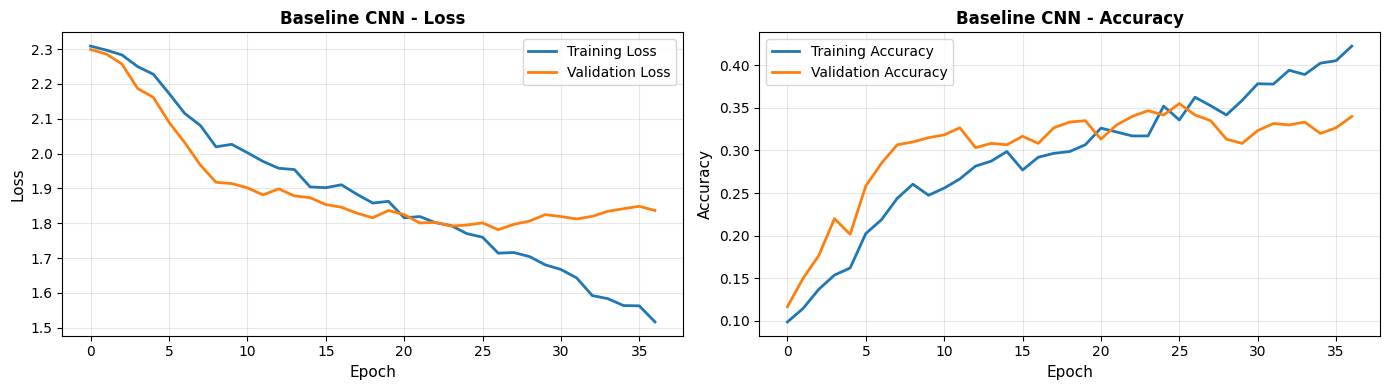

✓ Training completed in 37 epochs
  Best validation accuracy: 35.50%


In [6]:
# Plot training history for baseline model
def make_chart():
  fig, axes = plt.subplots(1, 2, figsize=(14, 4))

  # Plot loss
  axes[0].plot(history_baseline.history['loss'], label='Training Loss', linewidth=2)
  axes[0].plot(history_baseline.history['val_loss'], label='Validation Loss', linewidth=2)
  axes[0].set_xlabel('Epoch', fontsize=11)
  axes[0].set_ylabel('Loss', fontsize=11)
  axes[0].set_title('Baseline CNN - Loss', fontsize=12, fontweight='bold')
  axes[0].legend()
  axes[0].grid(True, alpha=0.3)

  # Plot accuracy
  axes[1].plot(history_baseline.history['accuracy'], label='Training Accuracy', linewidth=2)
  axes[1].plot(history_baseline.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
  axes[1].set_xlabel('Epoch', fontsize=11)
  axes[1].set_ylabel('Accuracy', fontsize=11)
  axes[1].set_title('Baseline CNN - Accuracy', fontsize=12, fontweight='bold')
  axes[1].legend()
  axes[1].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

  print(f"✓ Training completed in {len(history_baseline.history['loss'])} epochs")
  print(f"  Best validation accuracy: {max(history_baseline.history['val_accuracy'])*100:.2f}%")

make_chart()

In [7]:
# Prepare data for multi-task training
X_train_mtl = X_train[..., None].astype('float32')
X_val_mtl = X_val[..., None].astype('float32')

# Normalize
mean = X_train_mtl.mean()
std = X_train_mtl.std() + 1e-6
X_train_mtl = (X_train_mtl - mean) / std
X_val_mtl = (X_val_mtl - mean) / std

# Extract targets
y_A_train, y_B_train, y_C_train = y_train[:, 0], y_train[:, 1], y_train[:, 2]
y_A_val, y_B_val, y_C_val = y_val[:, 0], y_val[:, 1], y_val[:, 2]


import numpy as np

NUM_BINS = 32

def bin_to_sincos(y_bin, num_bins=NUM_BINS):
    angles = 2 * np.pi * y_bin / num_bins
    return np.stack([np.sin(angles), np.cos(angles)], axis=1)

y_B_train_sc = bin_to_sincos(y_B_train)
y_B_val_sc   = bin_to_sincos(y_B_val)

print("Data prepared for multi-task learning:")
print(f"  X_train: {X_train_mtl.shape}")
print(f"  X_val: {X_val_mtl.shape}")
print(f"  Target A: {y_A_train.shape} (10 classes)")
print(f"  Target B: {y_B_train.shape} (32 classes)")
print(f"  Target C: {y_C_train.shape} (regression [{y_C_train.min():.4f}, {y_C_train.max():.4f}])")

Data prepared for multi-task learning:
  X_train: (2400, 32, 32, 1)
  X_val: (600, 32, 32, 1)
  Target A: (2400,) (10 classes)
  Target B: (2400,) (32 classes)
  Target C: (2400,) (regression [0.0003, 0.9996])


In [8]:
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.regularizers import l2


def build_hypothesis_mtl_model():
    inputs = Input(shape=(32, 32, 1), name="input_image")

    # ------------------------
    # Shared backbone
    # ------------------------
    x = Conv2D(32, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(2)(x)  # 16x16

    x = Conv2D(64, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(2)(x)  # 8x8

    x = Conv2D(128, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    shared_features = x  # 8x8x128

    # ========================
    # HEAD A: Global Shape (10)
    # ========================
    a = Conv2D(128, 3, padding="same", activation="relu")(shared_features)
    a = GlobalAveragePooling2D(name="head_a_gap")(a)
    a = Dense(64, activation="relu")(a)
    a = Dropout(0.5)(a)
    output_a = Dense(
        10, activation="softmax", name="output_A", kernel_regularizer=l2(1e-2)
    )(a)

    # HEAD B: Orientation (32)
    # HEAD B: Orientation / Fine Structure (spatially preserved)

    b = Conv2D(128, 3, padding="same", activation="relu")(shared_features)
    b = Conv2D(128, 3, padding="same", activation="relu")(b)
    b = MaxPooling2D(2)(b)  # 8x8 → 4x4 (still spatial)
    b = layers.Flatten()(b)
    b = Dense(256, activation="relu", kernel_regularizer=l2(1e-3))(b)
    b = Dropout(0.5)(b)
    output_b = Dense(32, activation="softmax", name="output_B")(b)

    # ========================
    # HEAD C: Intensity (reg)
    # ========================
    c = layers.Lambda(lambda x: tf.stop_gradient(x), name="stopgrad_C")(shared_features)

    c = GlobalAveragePooling2D(name="head_c_gap")(c)
    c = Dense(32, activation="relu")(c)
    c = Dropout(0.3)(c)
    output_c = Dense(1, activation="sigmoid", name="output_C")(c)

    model = Model(
        inputs=inputs,
        outputs=[output_a, output_b, output_c],
        name="hypothesis_mtl_model",
    )

    model.compile(
        optimizer=Adam(learning_rate=1e-3, clipnorm=1.0),
        loss={
            "output_A": "sparse_categorical_crossentropy",
            "output_B": "sparse_categorical_crossentropy",
            "output_C": "mse",
        },
        loss_weights={
            "output_A": 0.7,
            "output_B": 1.2,  # ↑ slightly stronger than before
            "output_C": 0.15,
        },
        metrics={
            "output_A": "accuracy",
            "output_B": "accuracy",
            "output_C": "mae",
        },
    )

    return model


from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf


def build_hypothesis_mtl_model_v2():
    inputs = Input(shape=(32, 32, 1), name="input_image")

    # ========================
    # Early shared stem
    # ========================
    x = Conv2D(32, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # ========================
    # SPLIT HERE (critical)
    # ========================

    # ---------- Path A & C (shape / intensity)
    ac = MaxPooling2D(2)(x)  # 16x16
    ac = Conv2D(64, 3, padding="same")(ac)
    ac = BatchNormalization()(ac)
    ac = Activation("relu")(ac)
    ac = MaxPooling2D(2)(ac)  # 8x8
    ac = Conv2D(128, 3, padding="same", activation="relu")(ac)

    # ---------- Path B (orientation-sensitive)
    b = Conv2D(64, 3, padding="same", activation="relu")(x)  # stays 32x32
    b = MaxPooling2D(2)(b)  # 16x16
    b = Conv2D(128, 3, padding="same", activation="relu")(b)
    b = MaxPooling2D(2)(b)  # 8x8
    b = Conv2D(128, 3, padding="same", activation="relu")(b)

    # ========================
    # HEAD A: Global Shape
    # ========================
    a = GlobalAveragePooling2D(name="head_a_gap")(ac)
    a = Dense(64, activation="relu")(a)
    a = Dropout(0.5)(a)
    output_a = Dense(
        10,
        activation="softmax",
        name="output_A",
        kernel_regularizer=l2(1e-3),  # ↓ slightly weaker reg
    )(a)

    # ========================
    # HEAD B: Orientation
    # ========================
    b = layers.Flatten()(b)
    b = Dense(256, activation="relu")(b)
    b = Dropout(0.5)(b)
    output_b = Dense(32, activation="softmax", name="output_B")(b)

    # ========================
    # HEAD C: Intensity (safe)
    # ========================
    c = layers.Lambda(lambda x: tf.stop_gradient(x), name="stopgrad_C")(ac)
    c = GlobalAveragePooling2D(name="head_c_gap")(c)
    c = Dense(32, activation="relu")(c)
    c = Dropout(0.3)(c)
    output_c = Dense(1, activation="sigmoid", name="output_C")(c)

    model = Model(inputs, [output_a, output_b, output_c])

    model.compile(
        optimizer=Adam(learning_rate=1e-3, clipnorm=1.0),
        loss={
            "output_A": "sparse_categorical_crossentropy",
            "output_B": "sparse_categorical_crossentropy",
            "output_C": "mse",
        },
        loss_weights={
            "output_A": 0.6,  # ↓
            "output_B": 1.5,  # ↑ critical
            "output_C": 0.15,
        },
        metrics={
            "output_A": "accuracy",
            "output_B": "accuracy",
            "output_C": "mae",
        },
    )

    return model


# Build the model
hypothesis_model = build_hypothesis_mtl_model_v2()
# hypothesis_model.summary()

In [12]:
# Train the hypothesis-driven MTL model
def train():

    print("Training hypothesis-driven multi-task model...")
    print("=" * 60)

    # callbacks_mtl = [
    #     EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    #     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
    # ]
    callbacks_mtl = [
        EarlyStopping(
            monitor="val_output_B_accuracy",
            mode="max",
            patience=8,
            restore_best_weights=True,
        ),
        # EarlyStopping(
        #     monitor="val_output_B_loss", mode="min", patience=12, restore_best_weights=True
        # ),
        # EarlyStopping(
        #     monitor="val_output_B_mae", mode="min", patience=5, restore_best_weights=True
        # ),
        # EarlyStopping(monitor="val_output_B_loss", patience=12, restore_best_weights=True),
        ReduceLROnPlateau(
            monitor="val_output_B_accuracy",
            mode="max",
            factor=0.7,
            patience=10,
            min_lr=1e-6,
        ),
    ]

    history_mtl = hypothesis_model.fit(
        X_train_mtl,
        {"output_A": y_A_train, "output_B": y_B_train, "output_C": y_C_train},
        # {"output_A": y_A_train, "output_B": y_B_train_sc, "output_C": y_C_train},
        validation_data=(
            X_val_mtl,
            {"output_A": y_A_val, "output_B": y_B_val, "output_C": y_C_val},
            # {"output_A": y_A_val, "output_B": y_B_val_sc, "output_C": y_C_val},
        ),
        epochs=50,
        batch_size=64,
        callbacks=callbacks_mtl,
        verbose=2,
    )

    print("=" * 60)
    print("Training completed!")
    return history_mtl


history_mtl = train()

Training hypothesis-driven multi-task model...
Epoch 1/50
38/38 - 4s - 92ms/step - loss: 4.6855 - output_A_accuracy: 0.3025 - output_A_loss: 1.8983 - output_B_accuracy: 0.2729 - output_B_loss: 2.3506 - output_C_loss: 0.0560 - output_C_mae: 0.1930 - val_loss: 6.5852 - val_output_A_accuracy: 0.2333 - val_output_A_loss: 2.1273 - val_output_B_accuracy: 0.0633 - val_output_B_loss: 3.5369 - val_output_C_loss: 0.0578 - val_output_C_mae: 0.2041 - learning_rate: 0.0010
Epoch 2/50
38/38 - 3s - 90ms/step - loss: 4.5450 - output_A_accuracy: 0.3046 - output_A_loss: 1.8587 - output_B_accuracy: 0.2950 - output_B_loss: 2.2744 - output_C_loss: 0.0521 - output_C_mae: 0.1863 - val_loss: 7.3559 - val_output_A_accuracy: 0.1867 - val_output_A_loss: 2.7466 - val_output_B_accuracy: 0.0400 - val_output_B_loss: 3.7894 - val_output_C_loss: 0.0862 - val_output_C_mae: 0.2436 - learning_rate: 0.0010
Epoch 3/50
38/38 - 3s - 89ms/step - loss: 4.2726 - output_A_accuracy: 0.3038 - output_A_loss: 1.8524 - output_B_accur

In [13]:
# Evaluate hypothesis-driven MTL model
def evaluate():

    print("\n" + "=" * 60)
    print("HYPOTHESIS-DRIVEN MTL MODEL EVALUATION")
    print("=" * 60)

    # Get predictions
    y_pred_A, y_pred_B, y_pred_C = hypothesis_model.predict(X_val_mtl, verbose=0)

    # Convert predictions to class labels
    y_pred_A_labels = np.argmax(y_pred_A, axis=1)
    y_pred_B_labels = np.argmax(y_pred_B, axis=1)

    # Calculate accuracies
    acc_A = np.mean(y_pred_A_labels == y_A_val)
    acc_B = np.mean(y_pred_B_labels == y_B_val)
    mae_C = np.mean(np.abs(y_pred_C.squeeze() - y_C_val))

    print("\n✓ Target A (Global Shape/Geometry):")
    print(f"  Accuracy: {acc_A*100:.2f}%")
    print(f"  Random baseline: {1/10*100:.2f}%")

    print("\n✓ Target B (Orientation/Fine Structure):")
    print(f"  Accuracy: {acc_B*100:.2f}%")
    print(f"  Random baseline: {1/32*100:.2f}%")

    print("\n✓ Target C (Intensity/Amplitude):")
    print(f"  MAE: {mae_C:.4f}")
    print(f"  Range: [{y_C_val.min():.4f}, {y_C_val.max():.4f}]")

    # Comparison with baseline (Target A only)
    print("\n" + "=" * 60)
    print("COMPARISON WITH BASELINE")
    print("=" * 60)
    print(f"Baseline (Target A only): {val_acc*100:.2f}%")
    print(f"MTL Model (Target A):     {acc_A*100:.2f}%")
    improvement = (acc_A - val_acc) * 100
    print(f"Difference: {improvement:+.2f}%")
    print("=" * 60)

evaluate()


HYPOTHESIS-DRIVEN MTL MODEL EVALUATION

✓ Target A (Global Shape/Geometry):
  Accuracy: 21.17%
  Random baseline: 10.00%

✓ Target B (Orientation/Fine Structure):
  Accuracy: 8.17%
  Random baseline: 3.12%

✓ Target C (Intensity/Amplitude):
  MAE: 0.2174
  Range: [0.0035, 0.9984]

COMPARISON WITH BASELINE
Baseline (Target A only): 34.17%
MTL Model (Target A):     21.17%
Difference: -13.00%


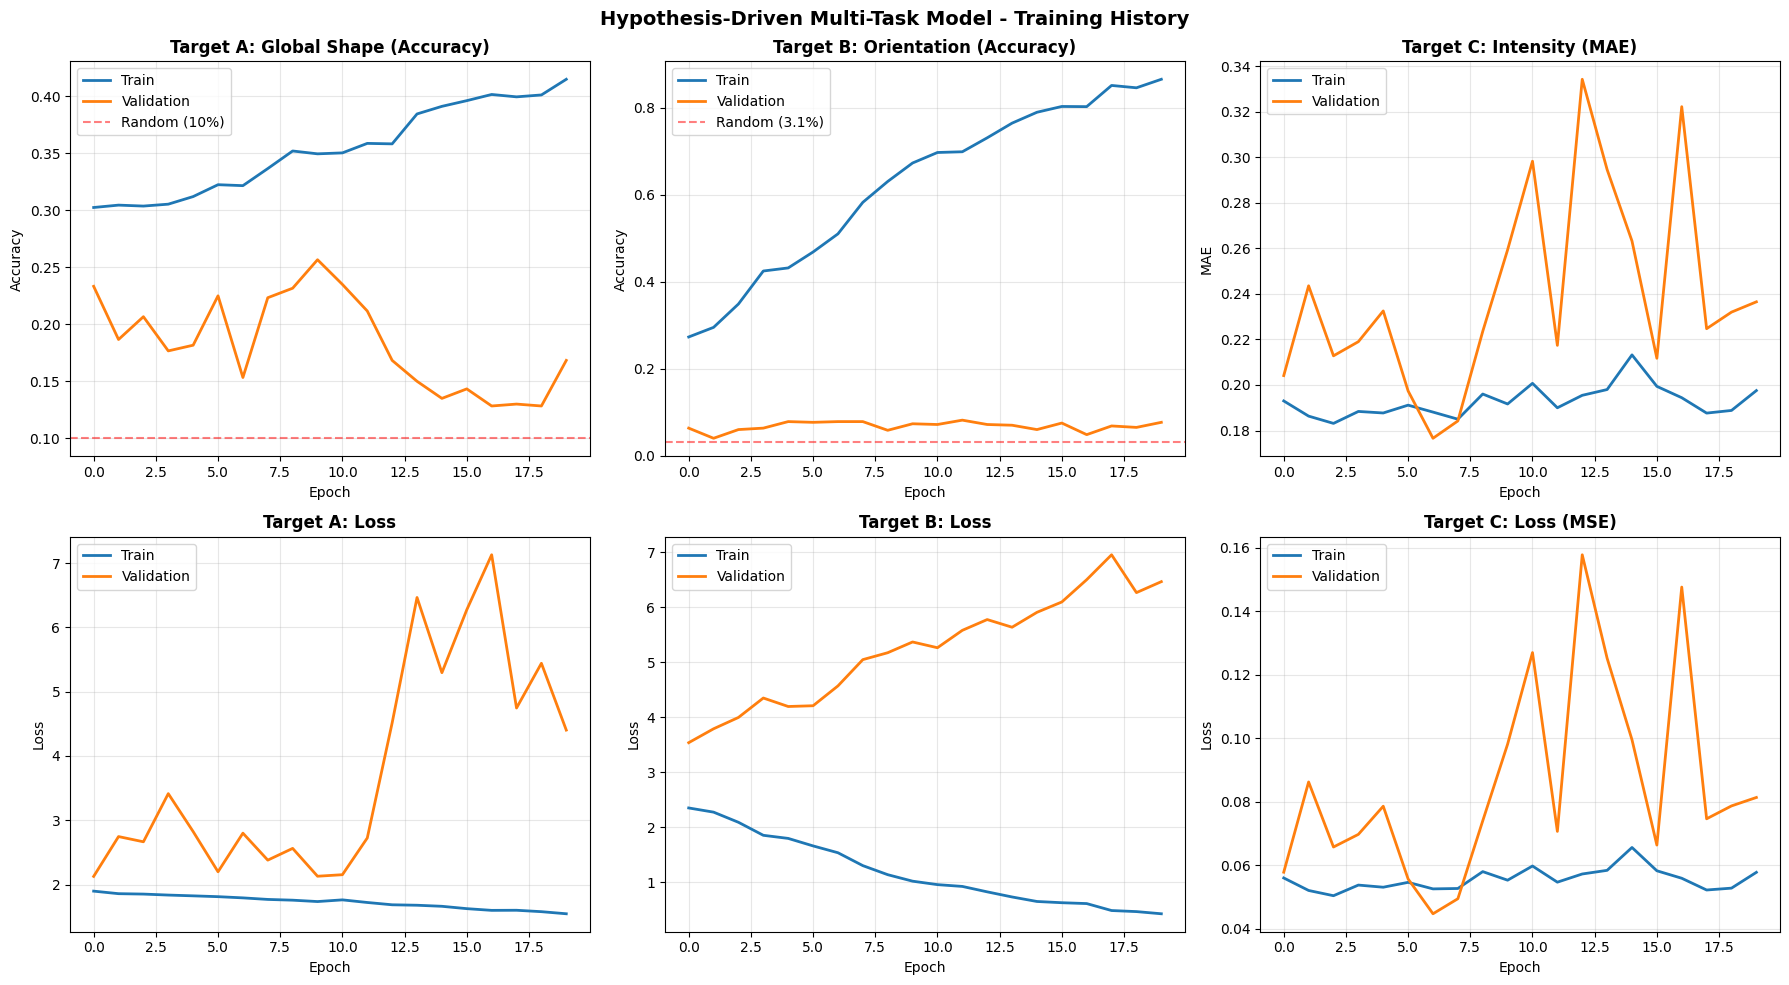


✓ Training completed in 20 epochs
  Best validation - Target A: 25.67%
  Best validation - Target B: 8.17%
  Best validation - Target C: 0.1766 MAE


In [14]:
# Plot training history for MTL model
def plot():
  fig, axes = plt.subplots(2, 3, figsize=(18, 10))
  fig.suptitle('Hypothesis-Driven Multi-Task Model - Training History', fontsize=14, fontweight='bold')

  # Target A - Accuracy
  axes[0, 0].plot(history_mtl.history['output_A_accuracy'], label='Train', linewidth=2)
  axes[0, 0].plot(history_mtl.history['val_output_A_accuracy'], label='Validation', linewidth=2)
  axes[0, 0].axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='Random (10%)')
  axes[0, 0].set_title('Target A: Global Shape (Accuracy)', fontweight='bold')
  axes[0, 0].set_xlabel('Epoch')
  axes[0, 0].set_ylabel('Accuracy')
  axes[0, 0].legend()
  axes[0, 0].grid(True, alpha=0.3)

  # Target A - Loss
  axes[1, 0].plot(history_mtl.history['output_A_loss'], label='Train', linewidth=2)
  axes[1, 0].plot(history_mtl.history['val_output_A_loss'], label='Validation', linewidth=2)
  axes[1, 0].set_title('Target A: Loss', fontweight='bold')
  axes[1, 0].set_xlabel('Epoch')
  axes[1, 0].set_ylabel('Loss')
  axes[1, 0].legend()
  axes[1, 0].grid(True, alpha=0.3)

  # Target B - Accuracy
  axes[0, 1].plot(history_mtl.history['output_B_accuracy'], label='Train', linewidth=2)
  axes[0, 1].plot(history_mtl.history['val_output_B_accuracy'], label='Validation', linewidth=2)
  axes[0, 1].axhline(y=1/32, color='r', linestyle='--', alpha=0.5, label='Random (3.1%)')
  axes[0, 1].set_title('Target B: Orientation (Accuracy)', fontweight='bold')
  axes[0, 1].set_xlabel('Epoch')
  axes[0, 1].set_ylabel('Accuracy')
  axes[0, 1].legend()
  axes[0, 1].grid(True, alpha=0.3)

  # Target B - Loss
  axes[1, 1].plot(history_mtl.history['output_B_loss'], label='Train', linewidth=2)
  axes[1, 1].plot(history_mtl.history['val_output_B_loss'], label='Validation', linewidth=2)
  axes[1, 1].set_title('Target B: Loss', fontweight='bold')
  axes[1, 1].set_xlabel('Epoch')
  axes[1, 1].set_ylabel('Loss')
  axes[1, 1].legend()
  axes[1, 1].grid(True, alpha=0.3)

  # Target C - MAE
  axes[0, 2].plot(history_mtl.history['output_C_mae'], label='Train', linewidth=2)
  axes[0, 2].plot(history_mtl.history['val_output_C_mae'], label='Validation', linewidth=2)
  axes[0, 2].set_title('Target C: Intensity (MAE)', fontweight='bold')
  axes[0, 2].set_xlabel('Epoch')
  axes[0, 2].set_ylabel('MAE')
  axes[0, 2].legend()
  axes[0, 2].grid(True, alpha=0.3)

  # Target C - Loss (MSE)
  axes[1, 2].plot(history_mtl.history['output_C_loss'], label='Train', linewidth=2)
  axes[1, 2].plot(history_mtl.history['val_output_C_loss'], label='Validation', linewidth=2)
  axes[1, 2].set_title('Target C: Loss (MSE)', fontweight='bold')
  axes[1, 2].set_xlabel('Epoch')
  axes[1, 2].set_ylabel('Loss')
  axes[1, 2].legend()
  axes[1, 2].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

  print(f"\n✓ Training completed in {len(history_mtl.history['loss'])} epochs")
  print(f"  Best validation - Target A: {max(history_mtl.history['val_output_A_accuracy'])*100:.2f}%")
  print(f"  Best validation - Target B: {max(history_mtl.history['val_output_B_accuracy'])*100:.2f}%")
  print(f"  Best validation - Target C: {min(history_mtl.history['val_output_C_mae']):.4f} MAE")

plot()

## Improved Model: Better Task-Specific Architecture

Based on insights from `insight.md`, this improved model addresses the key issues:
1. **Target A**: Needs more shared features before splitting (current model splits too early)
2. **Target B**: Needs dedicated spatial-preserving branch with delayed pooling
3. **Target C**: Can use stop_gradient to prevent interference
4. **Better regularization**: Residual connections, better normalization, data augmentation


In [ ]:
def build_improved_mtl_model():
    """
    Improved MTL model based on insights:
    - Deeper shared backbone for Target A & C (helps Target A)
    - Target B branches early (from 32x32) to preserve spatial info (like v2)
    - Residual connections for better gradient flow
    - Data augmentation
    - Optimized loss weighting
    """
    inputs = Input(shape=(32, 32, 1), name="input_image")
    
    # Data augmentation (only during training)
    x = layers.RandomRotation(factor=0.05, fill_mode='nearest')(inputs)
    x = layers.RandomZoom(height_factor=0.05, width_factor=0.05, fill_mode='nearest')(x)
    
    # ========================
    # Shared Backbone (deeper for Target A & C)
    # ========================
    # First conv block
    x = Conv2D(32, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(32, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # ========================
    # SPLIT: Target B branches early (preserves spatial info)
    # ========================
    # Target B branch - starts from 32x32 (like v2) to preserve spatial info
    b_early = Conv2D(64, 3, padding="same", activation="relu")(x)  # 32x32
    b_early = MaxPooling2D(2)(b_early)  # 16x16
    b_early = Conv2D(128, 3, padding="same", activation="relu")(b_early)
    b_early = MaxPooling2D(2)(b_early)  # 8x8
    b_early = Conv2D(128, 3, padding="same", activation="relu")(b_early)
    
    # Continue shared backbone for Target A & C
    x = MaxPooling2D(2)(x)  # 16x16
    
    # Second conv block with residual-like structure
    residual = x
    x = Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    # Project residual to match dimensions (32 -> 64 channels)
    residual_proj = Conv2D(64, 1, padding="same", use_bias=False)(residual)
    residual_proj = BatchNormalization()(residual_proj)
    x = Add()([residual_proj, x])
    x = Activation("relu")(x)
    x = MaxPooling2D(2)(x)  # 8x8
    
    # Third conv block
    x = Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Shared features at 8x8x128 (for Target A & C)
    shared_features = x
    
    # ========================
    # HEAD A: Global Shape (10-class)
    # ========================
    # Target A benefits from global pooling
    a = Conv2D(128, 3, padding="same", activation="relu")(shared_features)
    a = BatchNormalization()(a)
    a = GlobalAveragePooling2D(name="head_a_gap")(a)
    a = Dense(128, activation="relu", kernel_regularizer=l2(1e-4))(a)
    a = Dropout(0.4)(a)
    a = Dense(64, activation="relu", kernel_regularizer=l2(1e-4))(a)
    a = Dropout(0.3)(a)
    output_a = Dense(10, activation="softmax", name="output_A")(a)
    
    # ========================
    # HEAD B: Orientation (32-class) - Spatial Preserving (branches early)
    # ========================
    # Target B branches early to preserve spatial information (like v2)
    b = layers.Flatten()(b_early)
    b = Dense(256, activation="relu", kernel_regularizer=l2(1e-4))(b)
    b = Dropout(0.5)(b)
    output_b = Dense(32, activation="softmax", name="output_B")(b)
    
    # ========================
    # HEAD C: Intensity (Regression)
    # ========================
    # Target C is easiest - use stop_gradient to prevent interference
    c = layers.Lambda(lambda x: tf.stop_gradient(x), name="stopgrad_C")(shared_features)
    c = GlobalAveragePooling2D(name="head_c_gap")(c)
    c = Dense(64, activation="relu")(c)
    c = Dropout(0.2)(c)
    c = Dense(32, activation="relu")(c)
    output_c = Dense(1, activation="sigmoid", name="output_C")(c)
    
    model = Model(inputs=inputs, outputs=[output_a, output_b, output_c], name="improved_mtl_model")
    
    # Optimized loss weights based on task difficulty
    model.compile(
        optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0),
        loss={
            "output_A": "sparse_categorical_crossentropy",
            "output_B": "sparse_categorical_crossentropy",
            "output_C": "mse",
        },
        loss_weights={
            "output_A": 0.6,   # Similar to v2
            "output_B": 1.5,   # Higher weight for difficult Target B (like v2)
            "output_C": 0.15,  # Lower weight for easy Target C (like v2)
        },
        metrics={
            "output_A": "accuracy",
            "output_B": "accuracy",
            "output_C": "mae",
        },
    )
    
    return model

# Build improved model
improved_model = build_improved_mtl_model()
improved_model.summary()


Model: "improved_mtl_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 32, 32, 1) │          0 │ input_image[0][0] │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 32, 32, 1) │          0 │ random_rotation[… │
│ (RandomZoom)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │        288 │ random_zoom[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │      9,216 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │     18,432 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 16,    │      2,048 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │     36,864 │ activation_4[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_12[0][0] 

 Total params: 3,893,387 (14.85 MB)

 Trainable params: 3,891,083 (14.84 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [ ]:
# Train the improved MTL model
print("Training improved multi-task model...")
print("=" * 60)

callbacks_improved = [
    EarlyStopping(
        monitor="val_output_B_accuracy",
        mode="max",
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_output_B_accuracy",
        mode="max",
        factor=0.7,
        patience=10,
        min_lr=1e-6,
        verbose=1
    ),
]

history_improved = improved_model.fit(
    X_train_mtl,
    {"output_A": y_A_train, "output_B": y_B_train, "output_C": y_C_train},
    validation_data=(
        X_val_mtl,
        {"output_A": y_A_val, "output_B": y_B_val, "output_C": y_C_val},
    ),
    epochs=80,
    batch_size=64,
    callbacks=callbacks_improved,
    verbose=2,
)

print("=" * 60)
print("Training completed!")


Training improved multi-task model...
Epoch 1/80
38/38 - 13s - 353ms/step - loss: 9.9548 - output_A_accuracy: 0.1658 - output_A_loss: 2.2267 - output_B_accuracy: 0.0279 - output_B_loss: 3.7666 - output_C_loss: 0.0818 - output_C_mae: 0.2460 - val_loss: 9.3926 - val_output_A_accuracy: 0.1150 - val_output_A_loss: 2.2761 - val_output_B_accuracy: 0.0367 - val_output_B_loss: 3.4659 - val_output_C_loss: 0.0774 - val_output_C_mae: 0.2379 - learning_rate: 0.0010
Epoch 2/80
38/38 - 6s - 151ms/step - loss: 9.2041 - output_A_accuracy: 0.2267 - output_A_loss: 2.1034 - output_B_accuracy: 0.0296 - output_B_loss: 3.4664 - output_C_loss: 0.0709 - output_C_mae: 0.2257 - val_loss: 9.8071 - val_output_A_accuracy: 0.0967 - val_output_A_loss: 2.6989 - val_output_B_accuracy: 0.0283 - val_output_B_loss: 3.4658 - val_output_C_loss: 0.0853 - val_output_C_mae: 0.2490 - learning_rate: 0.0010
Epoch 3/80
38/38 - 6s - 152ms/step - loss: 9.1236 - output_A_accuracy: 0.2508 - output_A_loss: 2.0466 - output_B_accuracy: 

In [17]:
# Evaluate improved MTL model
print("\n" + "=" * 60)
print("IMPROVED MTL MODEL EVALUATION")
print("=" * 60)

# Get predictions
y_pred_A_imp, y_pred_B_imp, y_pred_C_imp = improved_model.predict(X_val_mtl, verbose=0)

# Convert predictions to class labels
y_pred_A_labels_imp = np.argmax(y_pred_A_imp, axis=1)
y_pred_B_labels_imp = np.argmax(y_pred_B_imp, axis=1)

# Calculate accuracies
acc_A_imp = np.mean(y_pred_A_labels_imp == y_A_val)
acc_B_imp = np.mean(y_pred_B_labels_imp == y_B_val)
mae_C_imp = np.mean(np.abs(y_pred_C_imp.squeeze() - y_C_val))

print("\n✓ Target A (Global Shape/Geometry):")
print(f"  Accuracy: {acc_A_imp*100:.2f}%")
print(f"  Random baseline: {1/10*100:.2f}%")
print(f"  Baseline single-task: {val_acc*100:.2f}%")
print(f"  Previous MTL model: 14.00%")

print("\n✓ Target B (Orientation/Fine Structure):")
print(f"  Accuracy: {acc_B_imp*100:.2f}%")
print(f"  Random baseline: {1/32*100:.2f}%")
print(f"  Previous MTL model: 7.17%")

print("\n✓ Target C (Intensity/Amplitude):")
print(f"  MAE: {mae_C_imp:.4f}")
print(f"  Range: [{y_C_val.min():.4f}, {y_C_val.max():.4f}]")
print(f"  Previous MTL model: 0.2320 MAE")

# Comparison
print("\n" + "=" * 60)
print("IMPROVEMENT SUMMARY")
print("=" * 60)
print(f"Target A improvement: {(acc_A_imp - 0.14)*100:+.2f}% (vs previous MTL)")
print(f"Target B improvement: {(acc_B_imp - 0.0717)*100:+.2f}% (vs previous MTL)")
print(f"Target C improvement: {(0.2320 - mae_C_imp):.4f} MAE reduction")
print("=" * 60)



IMPROVED MTL MODEL EVALUATION

✓ Target A (Global Shape/Geometry):
  Accuracy: 25.17%
  Random baseline: 10.00%
  Baseline single-task: 34.17%
  Previous MTL model: 14.00%

✓ Target B (Orientation/Fine Structure):
  Accuracy: 3.00%
  Random baseline: 3.12%
  Previous MTL model: 7.17%

✓ Target C (Intensity/Amplitude):
  MAE: 0.2375
  Range: [0.0035, 0.9984]
  Previous MTL model: 0.2320 MAE

IMPROVEMENT SUMMARY
Target A improvement: +11.17% (vs previous MTL)
Target B improvement: -4.17% (vs previous MTL)
Target C improvement: -0.0055 MAE reduction


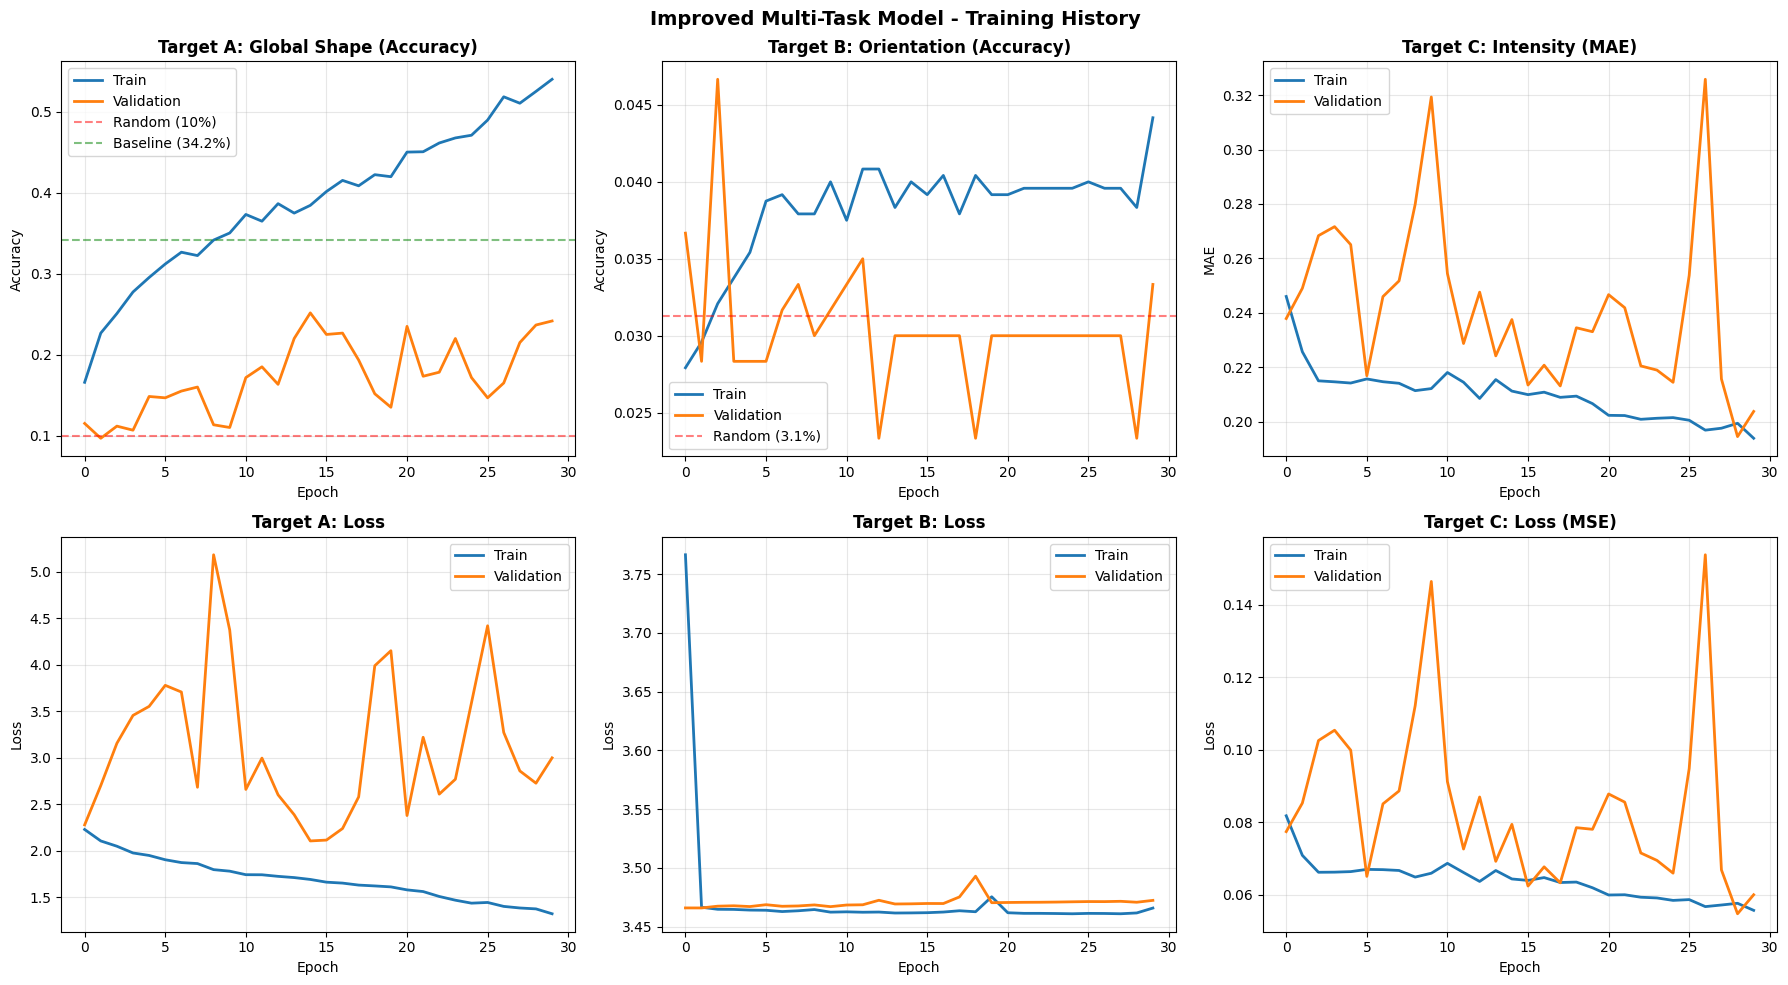


✓ Training completed in 30 epochs
  Best validation - Target A: 25.17%
  Best validation - Target B: 4.67%
  Best validation - Target C: 0.1945 MAE


In [18]:
# Plot training history for improved model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Improved Multi-Task Model - Training History', fontsize=14, fontweight='bold')

# Target A - Accuracy
axes[0, 0].plot(history_improved.history['output_A_accuracy'], label='Train', linewidth=2)
axes[0, 0].plot(history_improved.history['val_output_A_accuracy'], label='Validation', linewidth=2)
axes[0, 0].axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='Random (10%)')
axes[0, 0].axhline(y=val_acc, color='g', linestyle='--', alpha=0.5, label=f'Baseline ({val_acc*100:.1f}%)')
axes[0, 0].set_title('Target A: Global Shape (Accuracy)', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Target A - Loss
axes[1, 0].plot(history_improved.history['output_A_loss'], label='Train', linewidth=2)
axes[1, 0].plot(history_improved.history['val_output_A_loss'], label='Validation', linewidth=2)
axes[1, 0].set_title('Target A: Loss', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Target B - Accuracy
axes[0, 1].plot(history_improved.history['output_B_accuracy'], label='Train', linewidth=2)
axes[0, 1].plot(history_improved.history['val_output_B_accuracy'], label='Validation', linewidth=2)
axes[0, 1].axhline(y=1/32, color='r', linestyle='--', alpha=0.5, label='Random (3.1%)')
axes[0, 1].set_title('Target B: Orientation (Accuracy)', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Target B - Loss
axes[1, 1].plot(history_improved.history['output_B_loss'], label='Train', linewidth=2)
axes[1, 1].plot(history_improved.history['val_output_B_loss'], label='Validation', linewidth=2)
axes[1, 1].set_title('Target B: Loss', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Target C - MAE
axes[0, 2].plot(history_improved.history['output_C_mae'], label='Train', linewidth=2)
axes[0, 2].plot(history_improved.history['val_output_C_mae'], label='Validation', linewidth=2)
axes[0, 2].set_title('Target C: Intensity (MAE)', fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('MAE')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Target C - Loss (MSE)
axes[1, 2].plot(history_improved.history['output_C_loss'], label='Train', linewidth=2)
axes[1, 2].plot(history_improved.history['val_output_C_loss'], label='Validation', linewidth=2)
axes[1, 2].set_title('Target C: Loss (MSE)', fontweight='bold')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Training completed in {len(history_improved.history['loss'])} epochs")
print(f"  Best validation - Target A: {max(history_improved.history['val_output_A_accuracy'])*100:.2f}%")
print(f"  Best validation - Target B: {max(history_improved.history['val_output_B_accuracy'])*100:.2f}%")
print(f"  Best validation - Target C: {min(history_improved.history['val_output_C_mae']):.4f} MAE")
